In [1]:
#import library
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, f1_score

#### Reading File

In [2]:
df = pd.read_csv("../data/cleaned_data.csv")

In [3]:
df.head()

,Incident Hour,Precinct Of Incident Occurrence,year,in_news,month,Total Complaints_z_score,Total Substantiated Complaints_z_score,Officer Days On Force At Incident_zscore,news_hits,recent_prev_case,...,Officer Race_Asian,Officer Race_Black,Officer Race_Hispanic,Officer Race_White,Officer Gender_Female,Officer Gender_Male,Officer Gender_TGNC / Other,CCRB Complaint Disposition,PenaltyRecoded,PenaltyCount
0,7.0,63.0,2019.0,0.0,5.0,2.078182,-0.113459,1.349089,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Unsubstantiated,Not Applicable,Not Applicable
1,5.0,73.0,2014.0,0.0,8.0,-0.854419,-0.113459,1.751715,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Substantiated,Other,1
2,5.0,73.0,2014.0,0.0,8.0,-0.854419,-0.113459,1.751715,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Substantiated,Other,1
3,2.0,42.0,2019.0,0.0,2.0,-0.854419,-0.721040,-1.131105,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Exonerated,Not Applicable,Not Applicable
4,2.0,42.0,2019.0,0.0,2.0,-0.854419,-0.721040,-1.131105,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Exonerated,Not Applicable,Not Applicable


#### Setting up X and Y, Splitting Datasets, and SMOTE

In [4]:
#setting up y / complaint
complaint_label_encoder = LabelEncoder()
y = complaint_label_encoder.fit_transform(df["CCRB Complaint Disposition"])

In [5]:
# View the class-to-integer mapping
class_map = dict(zip(complaint_label_encoder.classes_, range(len(complaint_label_encoder.classes_))))
print("Class to Integer Mapping:", dict(zip(complaint_label_encoder.classes_, range(len(complaint_label_encoder.classes_)))))

Class to Integer Mapping: {'Exonerated': 0, 'Substantiated': 1, 'Unfounded': 2, 'Unsubstantiated': 3}


In [6]:
#setting up x and extracting ys for now
ys = df[["PenaltyRecoded", "PenaltyCount", "CCRB Complaint Disposition"]]
x = df.drop(columns = ["CCRB Complaint Disposition", "PenaltyRecoded", "PenaltyCount"])

In [7]:
#training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, stratify = y_train, random_state = 3)

In [8]:
#SMOTE for class imbalance
smote = SMOTE(random_state = 10)

In [9]:
#applying SMOTE to training
x_res, y_res = smote.fit_resample(x_train, y_train)

In [10]:
#check class dist
print(pd.Series(y_train).value_counts())
print(pd.Series(y_res).value_counts())

3    3196
1    2381
0     634
2     394
Name: count, dtype: int64
0    3196
1    3196
3    3196
2    3196
Name: count, dtype: int64


### Complaint Models

In [11]:
def model_perf(model:str, x_train, y_train, x, y):
    """
    runs and prints model performance
    depending on model argument
    """
    #determine and initialize mode
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, 
                             multi_class = "multinomial",
                             class_weight='balanced',
                             random_state = 2)
    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, 
                                     class_weight='balanced',
                                     random_state = 2)
    elif model == "SVM":
        mod = SVC(kernel='rbf',
                  class_weight='balanced',
                  random_state=2)
    elif model == "XGB":
        mod = XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            random_state=2)
        x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
        x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors=5)
        
    #fit model
    mod.fit(x_train, y_train)
    
    #compute predicted
    pred = mod.predict(x)
    
    #performance metrics
    conf_matrix = confusion_matrix(y, pred)
    class_report = classification_report(y, pred, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, pred)
    fl_weighted = f1_score(y, pred, average = 'weighted')
    f1_macro = f1_score(y, pred, average = 'macro')
    
    #printing report
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1-Weighted: {fl_weighted}')
    print(f'F1-Macro: {f1_macro}')
    print(conf_matrix)
    
    #confusion matrix plot 
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap='Blues')
    fig.colorbar(cax)

    # Add labels
    ax.set_xticks(np.arange(conf_matrix.shape[1]))
    ax.set_yticks(np.arange(conf_matrix.shape[0]))
    ax.set_xticklabels(list(class_map.keys()))
    ax.set_yticklabels(list(class_map.keys()))
    
    #remove outline
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Annotate the matrix with numbers
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center', color='black')

    plt.show()



C:\Users\helen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.23      0.40      0.29       159
           1       0.61      0.52      0.56       595
           2       0.12      0.41      0.19        99
           3       0.65      0.43      0.52       799

    accuracy                           0.46      1652
   macro avg       0.40      0.44      0.39      1652
weighted avg       0.56      0.46      0.49      1652

Balanced Accuracy: 0.4405858782815828
F1-Weighted: 0.49187661152972606
F1-Macro: 0.38911209585674555
[[ 63  32  40  24]
 [ 68 311  84 132]
 [ 22  11  41  25]
 [124 160 172 343]]


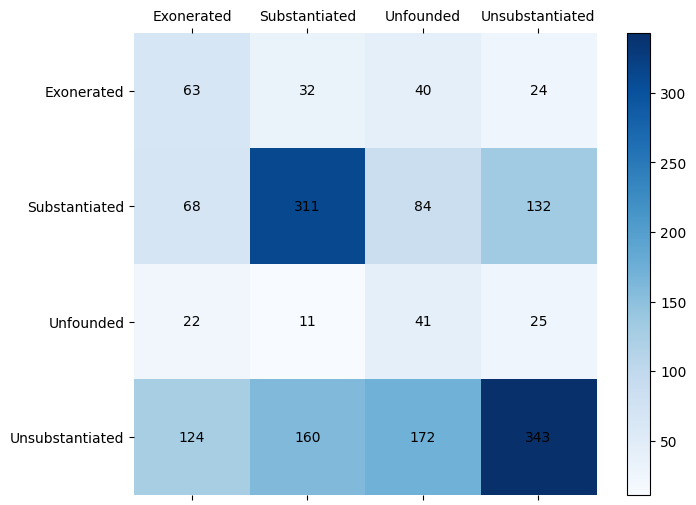

In [12]:
#logistic regression
model_perf("Logistic", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.90      0.45      0.60       159
           1       0.87      0.89      0.88       595
           2       0.90      0.64      0.75        99
           3       0.82      0.91      0.86       799

    accuracy                           0.84      1652
   macro avg       0.87      0.72      0.77      1652
weighted avg       0.85      0.84      0.84      1652

Balanced Accuracy: 0.7228706000118378
F1-Weighted: 0.8364764939907133
F1-Macro: 0.7723037990605304
[[ 72  20   2  65]
 [  1 528   1  65]
 [  0   4  63  32]
 [  7  57   4 731]]


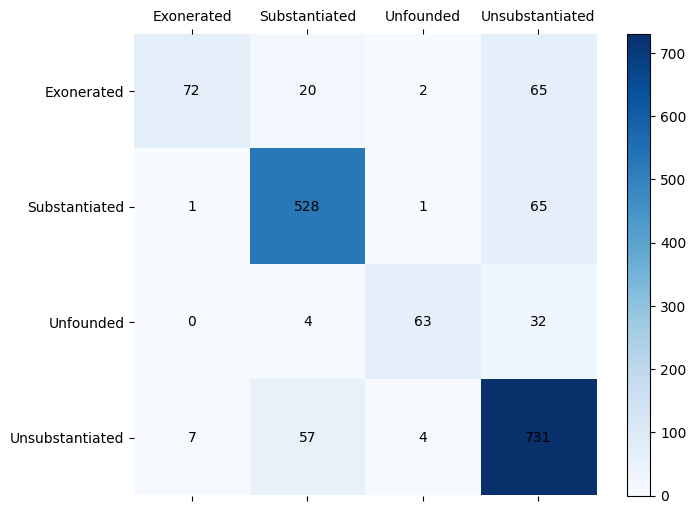

In [13]:
#random forest
model_perf("RF", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.08      0.40      0.14       159
           1       1.00      0.00      0.00       595
           2       0.09      0.17      0.12        99
           3       0.50      0.45      0.48       799

    accuracy                           0.27      1652
   macro avg       0.42      0.26      0.18      1652
weighted avg       0.62      0.27      0.25      1652

Balanced Accuracy: 0.25535975688524865
F1-Weighted: 0.252061043020741
F1-Macro: 0.18439074235356473
[[ 63   0  24  72]
 [281   1  64 249]
 [ 47   0  17  35]
 [356   0  82 361]]


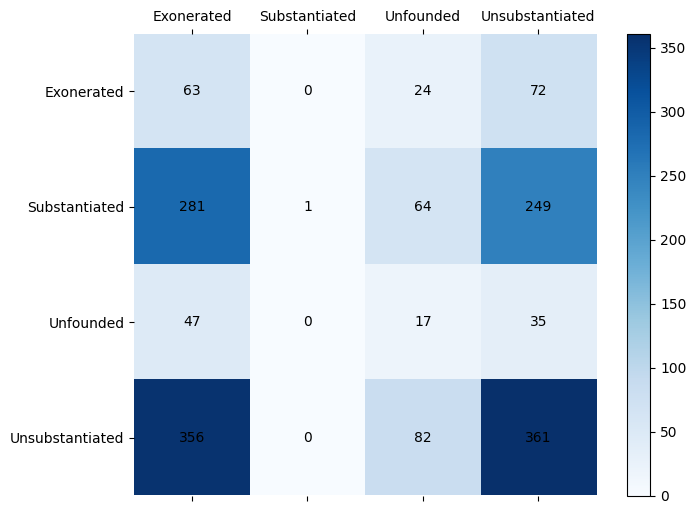

In [14]:
#svm
model_perf("SVM", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.83      0.48      0.61       159
           1       0.90      0.89      0.90       595
           2       0.89      0.69      0.78        99
           3       0.83      0.93      0.88       799

    accuracy                           0.86      1652
   macro avg       0.86      0.75      0.79      1652
weighted avg       0.86      0.86      0.85      1652

Balanced Accuracy: 0.7491067546077346
F1-Weighted: 0.8541042832005796
F1-Macro: 0.7913349699700364
[[ 77  14   3  65]
 [  4 532   2  57]
 [  0   5  68  26]
 [ 12  40   3 744]]


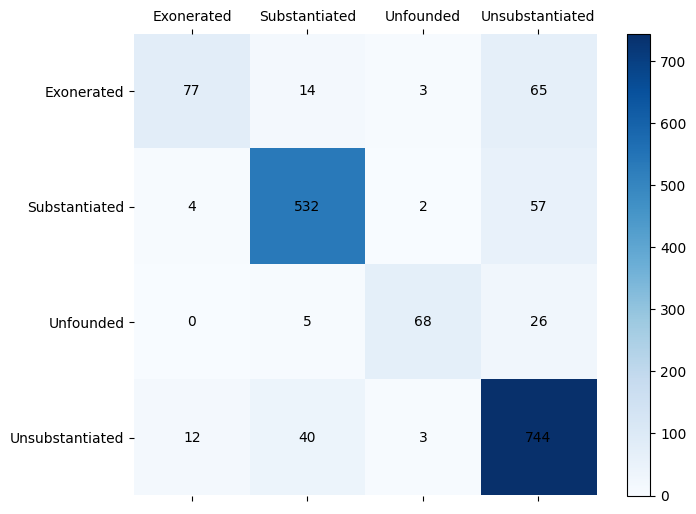

In [15]:
#XGBoost
model_perf("XGB", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.34      0.63      0.44       159
           1       0.78      0.76      0.77       595
           2       0.37      0.87      0.52        99
           3       0.88      0.59      0.71       799

    accuracy                           0.67      1652
   macro avg       0.59      0.71      0.61      1652
weighted avg       0.76      0.67      0.69      1652

Balanced Accuracy: 0.713578389033557
F1-Weighted: 0.6933036882204382
F1-Macro: 0.6091246706528152
[[100  21  21  17]
 [ 54 455  39  47]
 [  7   4  86   2]
 [135 104  87 473]]


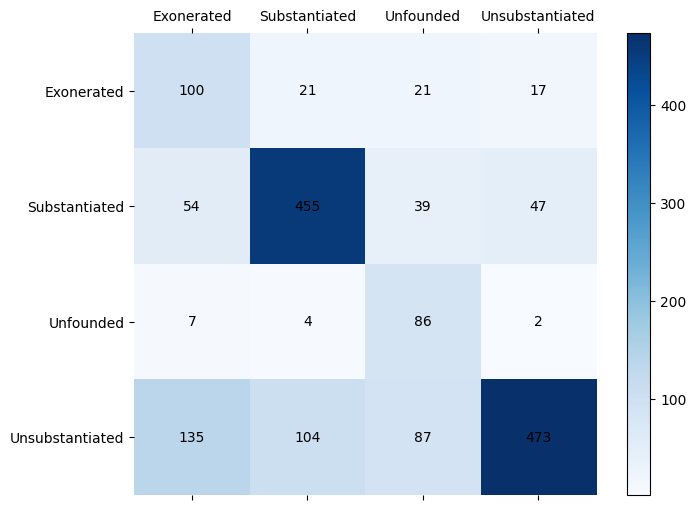

In [16]:
#KNN
model_perf("KNN", x_res, y_res, x_valid, y_valid)

#### Hyperparameter Tuning

In [17]:
#parameter to tune for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [18]:
#initiates rf
rf_tune = RandomForestClassifier(random_state = 2,
                               class_weight = "balanced")

In [19]:
#randomized search + cross validation
rf_gs = RandomizedSearchCV(rf_tune, rf_param_grid, cv = 5,
                     scoring = "f1_weighted",
                     n_jobs = -1)

In [20]:
rf_gs.fit(x_res, y_res)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=2),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 250,
                                                         300]},
                   scoring='f1_weighted')

In [21]:
#performance and best params
print("Best Parameters:", rf_gs.best_params_)
print("Best F1 Score (Weighted):", rf_gs.best_score_)

Best Parameters: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30}
Best F1 Score (Weighted): 0.8864699693567786


In [22]:
#parameters to tune for XG Boost
xgb_param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

In [23]:
#initiates xg boost
xgb_tuned = XGBClassifier(objective='multi:softmax', 
                            num_class=4,
                          random_state=2)

In [24]:
#randomized search + cross validation
xgb_sv = RandomizedSearchCV(xgb_tuned, xgb_param_grid, cv = 5,
                     scoring = "f1_weighted",
                     n_jobs = -1)

In [25]:
#fixes columns
x_res.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)

In [26]:
xgb_sv.fit(x_res, y_res)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=4, num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 6, 9],
                                        'min_child_weight': [1, 3, 5, 10],
                                        'n_estimators': [50, 100, 200, 250,
                                                         300],
                                        'subsample': [0.7, 0.8, 1.0]},
                   scoring='f1_weighted')

In [27]:
#performance and best params
print("Best Parameters:", xgb_sv.best_params_)
print("Best F1 Score (Weighted):", xgb_sv.best_score_)

Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
Best F1 Score (Weighted): 0.8746784989973959


#### Final Model Assessment

In [28]:
if xgb_sv.best_score_ > rf_gs.best_score_:
    complaint_mod = XGBClassifier(**xgb_sv.best_params_)
else:
    complaint_mod = RandomForestClassifier(**rf_gs.best_params_)

In [29]:
complaint_mod.fit(x_res, y_res)

RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=2,
                       n_estimators=250)

In [30]:
#compute predicted
x_test.columns = x_test.columns.str.replace(r'[\[\]<>]', '', regex=True)
complaint_pred = complaint_mod.predict(x_test)

In [31]:
#performance metrics
complaint_conf_matrix = confusion_matrix(y_test, complaint_pred)
complaint_class_report = classification_report(y_test, complaint_pred, zero_division = 0)
complaint_fl_weighted = f1_score(y_test, complaint_pred, average = 'weighted')

              precision    recall  f1-score   support

           0       0.86      0.45      0.59       199
           1       0.85      0.88      0.87       744
           2       0.81      0.49      0.61       123
           3       0.82      0.92      0.87       999

    accuracy                           0.83      2065
   macro avg       0.84      0.69      0.73      2065
weighted avg       0.84      0.83      0.83      2065

F1-Weighted: 0.8250836658415618


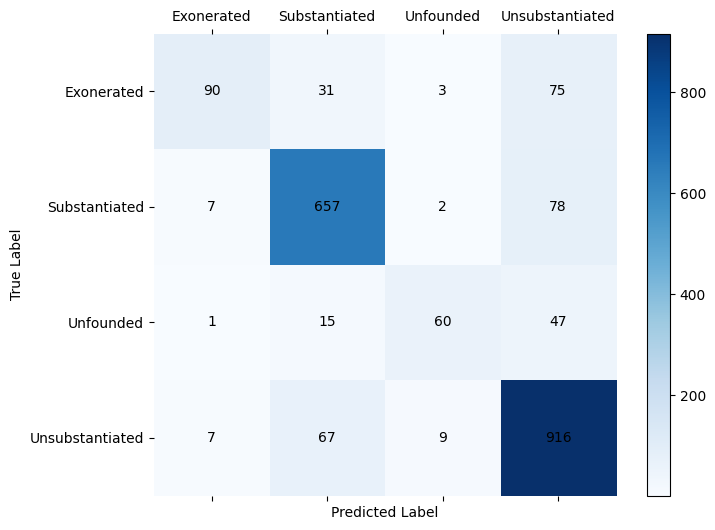

In [100]:
#printing report
print(complaint_class_report)
print(f'F1-Weighted: {complaint_fl_weighted}')

#confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(complaint_conf_matrix, cmap='Blues')
fig.colorbar(cax)

#add labels
ax.set_xticks(np.arange(complaint_conf_matrix.shape[1]))
ax.set_yticks(np.arange(complaint_conf_matrix.shape[0]))
ax.set_xticklabels(list(class_map.keys()))
ax.set_yticklabels(list(class_map.keys()))

#add axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

#remove outline
for spine in ax.spines.values():
    spine.set_visible(False)

# Annotate the matrix with numbers
for i in range(complaint_conf_matrix.shape[0]):
    for j in range(complaint_conf_matrix.shape[1]):
        ax.text(j, i, f'{complaint_conf_matrix[i, j]}', ha='center', va='center', color='black')

plt.show()

In [33]:
#most impt features
pd.DataFrame({
    'Feature': x_res.columns,
    'Importance': complaint_mod.feature_importances_
}).sort_values(by = 'Importance', ascending = False).head(20)

,Feature,Importance
6,Total Substantiated Complaints_z_score,0.083046
1,Precinct Of Incident Occurrence,0.053594
0,Incident Hour,0.045863
4,month,0.043457
7,Officer Days On Force At Incident_zscore,0.043454
5,Total Complaints_z_score,0.042111
2,year,0.040079
56,Reason for Police Contact_Suspect of Crime,0.025412
20,FADO Type_Abuse of Authority,0.025285
58,Outcome Of Police Encounter_Arrest,0.022058


In [34]:
#Complaint Mod
explainer = shap.Explainer(complaint_mod, x_train)
shap_values = explainer(x_test, check_additivity=False)

100%|===================| 8259/8260 [27:21<00:00]        

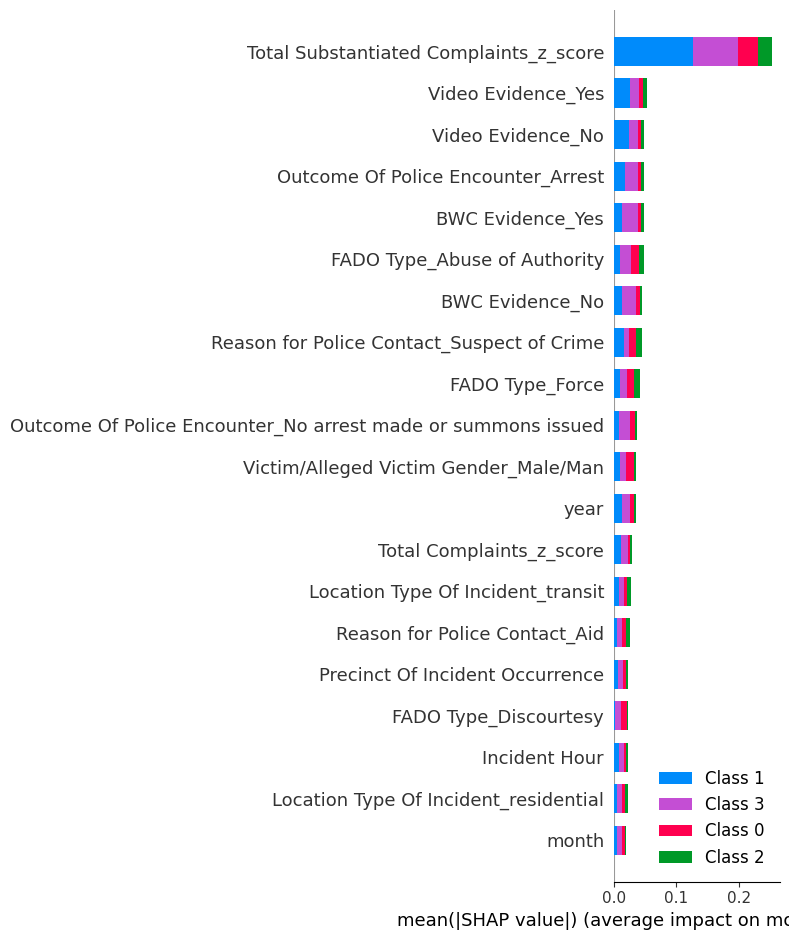

In [35]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
shap.summary_plot(shap_values, x_test, show=False)
plt.tight_layout()
plt.show()

#### Turning Complaints into Binary

In [36]:
#dichotomizing y
bin_y = np.where(ys['CCRB Complaint Disposition'] == "Substantiated",1, 0)

In [37]:
bin_map = {'Substantiated': 1, "Not Substantiated": 0}

In [38]:
#train test split
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, bin_y, test_size = 0.2, stratify = bin_y, random_state = 3)
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(x_train2, y_train2, test_size = 0.2, stratify = y_train2, random_state = 3)

In [39]:
#SMOTE for class imbalance
smote2 = SMOTE(random_state = 10)

#applying SMOTE to training
x_res2, y_res2 = smote2.fit_resample(x_train2, y_train2)

In [40]:
#check class dist
print(pd.Series(y_train2).value_counts())
print(pd.Series(y_res2).value_counts())

0    4224
1    2381
Name: count, dtype: int64
0    4224
1    4224
Name: count, dtype: int64


In [41]:
def model_perf_bin(model:str, x_train, y_train, x, y):
    """
    runs and prints model performance
    depending on model argument
    """
    #fix col names
    x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
    x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    
    #determine and initialize mode
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, 
                             class_weight='balanced',
                             random_state = 2)
    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, 
                                     class_weight='balanced',
                                     random_state = 2)
    elif model == "SVM":
        mod = SVC(kernel='rbf',
                  class_weight='balanced',
                  random_state=2)
    elif model == "XGB":
        mod = XGBClassifier(objective='binary:logistic', 
                            random_state=2)
    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors=5)
        
    #fit model
    mod.fit(x_train, y_train)
    
    #compute predicted
    pred = mod.predict(x)
    
    #performance metrics
    conf_matrix = confusion_matrix(y, pred)
    class_report = classification_report(y, pred, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, pred)
    fl_weighted = f1_score(y, pred, average = 'weighted')
    f1_macro = f1_score(y, pred, average = 'macro')
    
    #printing report
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1-Weighted: {fl_weighted}')
    print(f'F1-Macro: {f1_macro}')
    
    #confusion matrix plot
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap='Blues')
    fig.colorbar(cax)

    #add labels
    ax.set_xticks(np.arange(conf_matrix.shape[1]))
    ax.set_yticks(np.arange(conf_matrix.shape[0]))
    ax.set_xticklabels(list(bin_map.keys()))
    ax.set_yticklabels(list(bin_map.keys()))
    
    #add axis labels
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    #remove outline
    for spine in ax.spines.values():
        spine.set_visible(False)

    #annotate the matrix with numbers
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center', color='black')

    plt.show()

In [42]:
#list of models to go through
model_list = ["Logistic", "RF", "SVM", "XGB", "KNN"]

Logistic
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1057
           1       0.61      0.70      0.65       595

    accuracy                           0.73      1652
   macro avg       0.71      0.72      0.71      1652
weighted avg       0.74      0.73      0.73      1652

Balanced Accuracy: 0.7211252713005731
F1-Weighted: 0.7316338760054895
F1-Macro: 0.7134425274456544


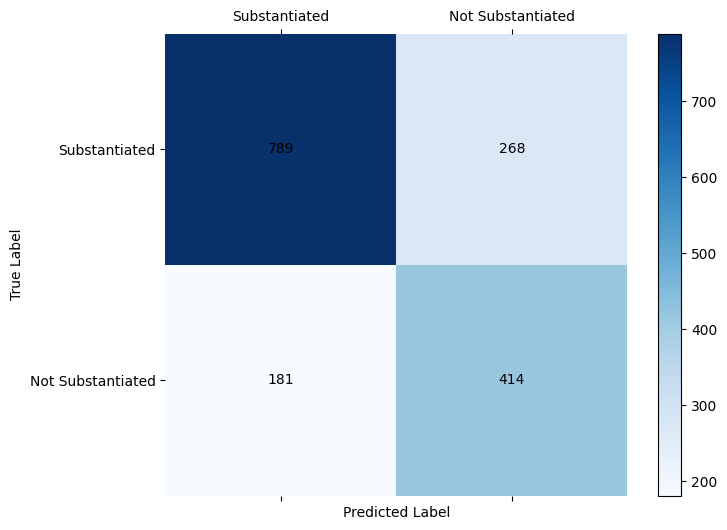

RF
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1057
           1       0.90      0.85      0.87       595

    accuracy                           0.91      1652
   macro avg       0.91      0.90      0.90      1652
weighted avg       0.91      0.91      0.91      1652

Balanced Accuracy: 0.8965663086426623
F1-Weighted: 0.9098031789176231
F1-Macro: 0.9015355074004625


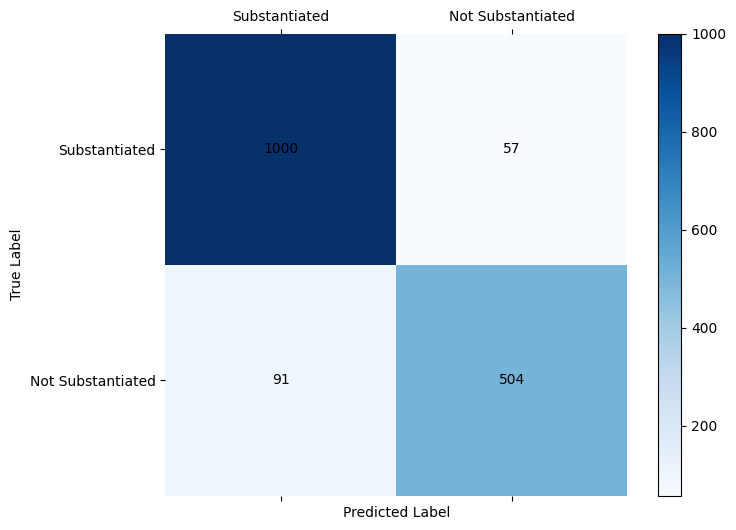

SVM
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1057
           1       1.00      0.00      0.00       595

    accuracy                           0.64      1652
   macro avg       0.82      0.50      0.39      1652
weighted avg       0.77      0.64      0.50      1652

Balanced Accuracy: 0.5008403361344538
F1-Weighted: 0.5006922616406231
F1-Macro: 0.39200281542137144


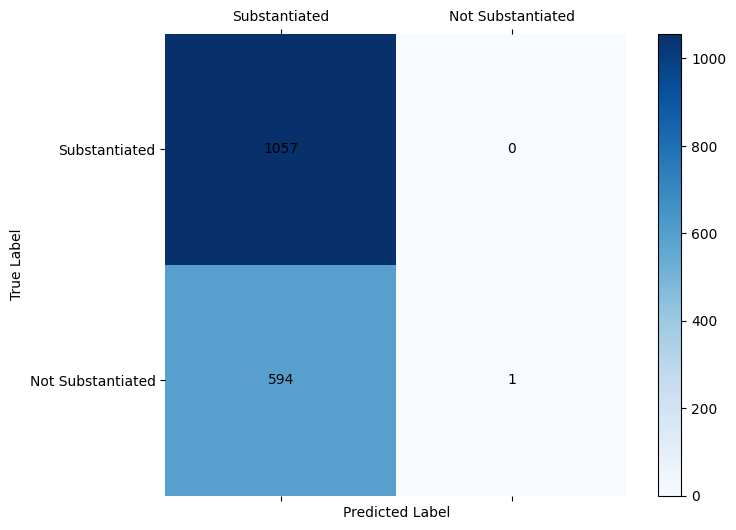

XGB
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1057
           1       0.90      0.89      0.89       595

    accuracy                           0.92      1652
   macro avg       0.92      0.92      0.92      1652
weighted avg       0.92      0.92      0.92      1652

Balanced Accuracy: 0.9162613389726751
F1-Weighted: 0.9242062130589737
F1-Macro: 0.917639274380071


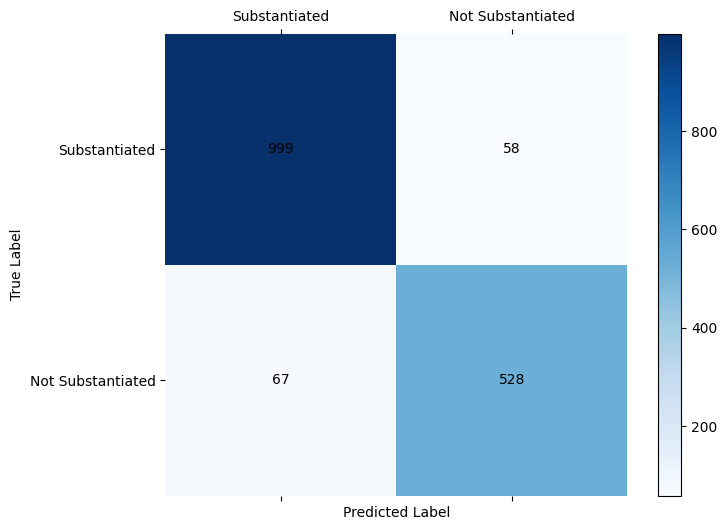

KNN
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1057
           1       0.69      0.83      0.75       595

    accuracy                           0.80      1652
   macro avg       0.79      0.81      0.79      1652
weighted avg       0.82      0.80      0.81      1652

Balanced Accuracy: 0.8086927486226279
F1-Weighted: 0.8058264259408127
F1-Macro: 0.7940417460208196


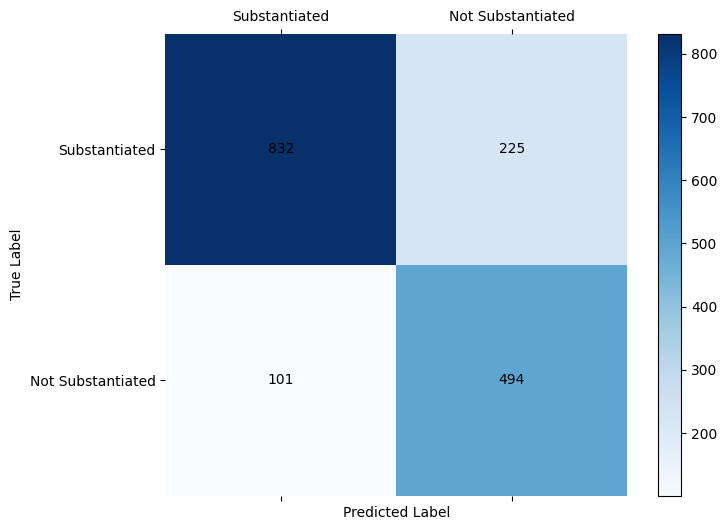

In [43]:
#fits and evaluates performance for each model
for model in model_list:
    print(model)
    model_perf_bin(model, x_res2, y_res2, x_valid2, y_valid2)

In [44]:
#parameter to tune for Random Forest and XGB
params_grid = {
    'RF': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
    },
    'XGB': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
    }
}

In [45]:
top_bin_models = ["RF", "XGB"]

In [46]:
score_storage = {}
param_storage = {}

In [47]:
#hyperparameter tuning
for top_mod in top_bin_models:
    #fix cols
    x_res2.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
    
    #initiate mod
    if top_mod == "RF":
        mod = RandomForestClassifier(random_state = 2,
                               class_weight = "balanced")
    elif top_mod == "XGB":
        mod = XGBClassifier(objective='binary:logistic', 
                            random_state=2)
        
    #randomized grid search
    rf_gs = RandomizedSearchCV(mod, params_grid[top_mod], cv = 5,
                     scoring = "f1_weighted",
                     n_iter = 100,
                     random_state = 42,
                     n_jobs = -1)
    
    #fit
    rf_gs.fit(x_res2, y_res2)
    
    #print best params and scoes
    print(f'Best Parameters for {top_mod}:', rf_gs.best_params_)
    print(f'Best F1 Score (Weighted) for {top_mod}:', rf_gs.best_score_)
    
    #append
    score_storage[top_mod] = rf_gs.best_score_
    param_storage[top_mod] = rf_gs.best_params_

Best Parameters for RF: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best F1 Score (Weighted) for RF: 0.9238111943511536
Best Parameters for XGB: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1.0}
Best F1 Score (Weighted) for XGB: 0.9265871028532932


In [48]:
#Final Assessment
if score_storage["XGB"] > score_storage["RF"]:
    complaint_mod_bin = XGBClassifier(**param_storage["XGB"])
else:
    complaint_mod_bin = RandomForestClassifier(**param_storage["RF"])

In [49]:
#fit mod
complaint_mod_bin.fit(x_res2, y_res2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [50]:
#compute predicted
x_test2.columns = x_test2.columns.str.replace(r'[\[\]<>]', '', regex=True)
complaint_pred_bin = complaint_mod_bin.predict(x_test2)

In [51]:
#performance metrics
complaint_bin_conf_matrix = confusion_matrix(y_test2, complaint_pred_bin)
complaint_bin_class_report = classification_report(y_test2, complaint_pred_bin, zero_division = 0)
complaint_bin_fl_weighted = f1_score(y_test2, complaint_pred_bin, average = 'weighted')

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1321
           1       0.91      0.90      0.91       744

    accuracy                           0.93      2065
   macro avg       0.93      0.93      0.93      2065
weighted avg       0.93      0.93      0.93      2065

F1-Weighted: 0.9336069932149182


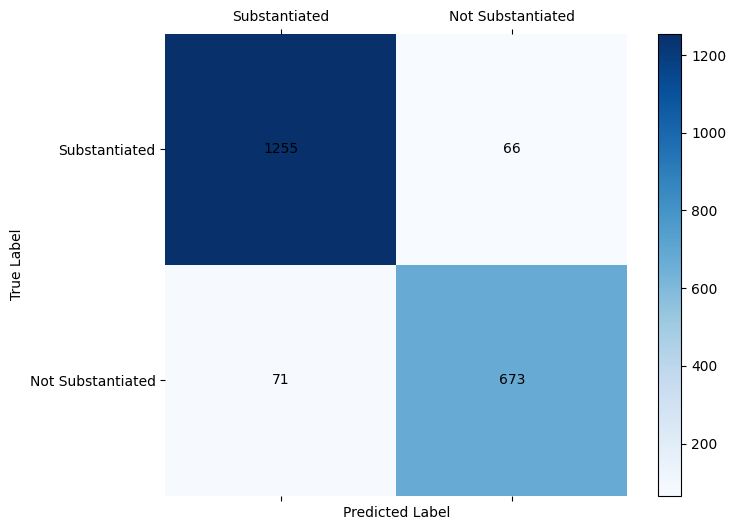

In [52]:
#printing report
print(complaint_bin_class_report)
print(f'F1-Weighted: {complaint_bin_fl_weighted}')

#confusion matrix plot 
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(complaint_bin_conf_matrix, cmap='Blues')
fig.colorbar(cax)

# Add labels
ax.set_xticks(np.arange(complaint_bin_conf_matrix.shape[1]))
ax.set_yticks(np.arange(complaint_bin_conf_matrix.shape[0]))
ax.set_xticklabels(list(bin_map.keys()))
ax.set_yticklabels(list(bin_map.keys()))

#add axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')


#remove outline
for spine in ax.spines.values():
    spine.set_visible(False)

# Annotate the matrix with numbers
for i in range(complaint_bin_conf_matrix.shape[0]):
    for j in range(complaint_bin_conf_matrix.shape[1]):
        ax.text(j, i, f'{complaint_bin_conf_matrix[i, j]}', ha='center', va='center', color='black')

plt.show()

In [53]:
pd.DataFrame({
    'Feature': x_res2.columns,
    'Importance': complaint_mod_bin.feature_importances_
}).sort_values(by = 'Importance', ascending = False).head(20)

,Feature,Importance
65,Video Evidence_Yes,0.123798
6,Total Substantiated Complaints_z_score,0.114621
11,recent_prev_penalty,0.042458
16,Officer Rank At Incident_Lieutenant,0.037116
22,FADO Type_Force,0.030920
62,BWC Evidence_No,0.027426
53,Reason for Police Contact_Executed Action,0.019385
64,Video Evidence_No,0.018140
20,FADO Type_Abuse of Authority,0.017142
10,recent_prev_subs,0.016983


In [54]:
#Bin Mod
explainer = shap.Explainer(complaint_mod_bin, x_train2)
shap_values = explainer(x_test2, check_additivity=False)

 98%|===================| 2030/2065 [00:15<00:00]        

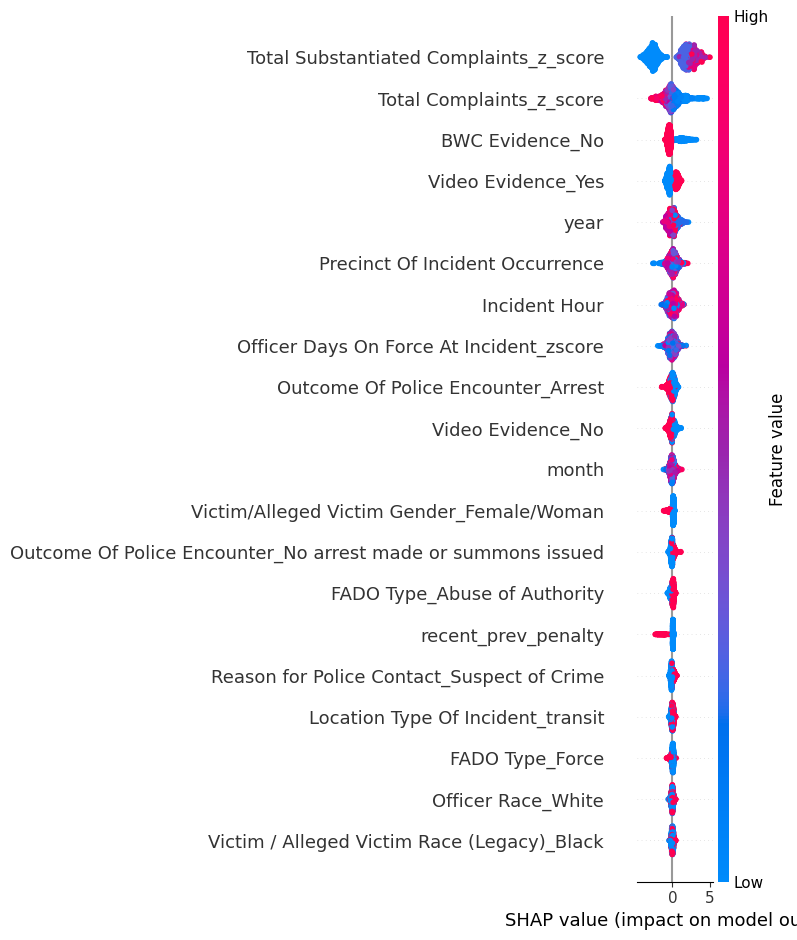

In [55]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
shap.summary_plot(shap_values, x_test2, show=False)
plt.tight_layout()
plt.show()

### Penalty Type Models

In [56]:
penalty_df = df.copy().query('PenaltyRecoded != "Not Applicable"')

In [57]:
penalty_df['PenaltyRecoded'].value_counts()

PenaltyRecoded
Formalized Training     671
Command Discipline A    558
Instructions            430
No Penalty              371
Vacation Loss           305
Command Discipline B    146
Other                    58
Name: count, dtype: int64

In [58]:
penalty_df.shape

(2539, 77)

In [59]:
#encoding penalty type
penalty_encoder = LabelEncoder()
y = penalty_encoder.fit_transform(penalty_df['PenaltyRecoded'])

In [60]:
# View the class-to-integer mapping
penalty_map = dict(zip(penalty_encoder.classes_, range(len(penalty_encoder.classes_))))
print("Class to Integer Mapping:", dict(zip(penalty_encoder.classes_, range(len(penalty_encoder.classes_)))))

Class to Integer Mapping: {'Command Discipline A': 0, 'Command Discipline B': 1, 'Formalized Training': 2, 'Instructions': 3, 'No Penalty': 4, 'Other': 5, 'Vacation Loss': 6}


In [61]:
x = penalty_df.drop(columns = ["PenaltyRecoded", "PenaltyCount", "CCRB Complaint Disposition"])

In [62]:
#training, validation, and test sets
x_train3, x_test3, y_train3, y_test3 = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 3)
x_train3, x_valid3, y_train3, y_valid3 = train_test_split(x_train3, y_train3, test_size = 0.2, stratify = y_train3, random_state = 3)

In [63]:
#SMOTE for class imbalance
smote_penalty = SMOTE(random_state = 10)

#applying SMOTE to training
x_res3, y_res3 = smote_penalty.fit_resample(x_train3, y_train3)

In [64]:
#check class dist
print(pd.Series(y_train3).value_counts())
print(pd.Series(y_res3).value_counts())

2    429
0    357
3    275
4    237
6    195
1     94
5     37
Name: count, dtype: int64
6    429
1    429
4    429
3    429
2    429
0    429
5    429
Name: count, dtype: int64


In [65]:
def model_perf_type(model:str, x_train, y_train, x, y):
    """
    runs and prints model performance
    depending on model argument
    """
    #determine and initialize mode
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, 
                             multi_class = "multinomial",
                             class_weight='balanced',
                             random_state = 2)
    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, 
                                     class_weight='balanced',
                                     random_state = 2)
    elif model == "SVM":
        mod = SVC(kernel='rbf',
                  class_weight='balanced',
                  random_state=2)
    elif model == "XGB":
        mod = XGBClassifier(objective='multi:softmax', 
                            num_class=7, 
                            random_state=2)
        x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
        x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors=5)
        
    #fit model
    mod.fit(x_train, y_train)
    
    #compute predicted
    pred = mod.predict(x)
    
    #performance metrics
    conf_matrix = confusion_matrix(y, pred)
    class_report = classification_report(y, pred, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, pred)
    fl_weighted = f1_score(y, pred, average = 'weighted')
    f1_macro = f1_score(y, pred, average = 'macro')
    
    #printing report
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1-Weighted: {fl_weighted}')
    print(f'F1-Macro: {f1_macro}')
    
    #confusion matrix plot 
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap='Blues')
    fig.colorbar(cax)

    #add labels
    ax.set_xticks(np.arange(conf_matrix.shape[1]))
    ax.set_yticks(np.arange(conf_matrix.shape[0]))
    ax.set_xticklabels(list(penalty_map.keys()))
    ax.set_yticklabels(list(penalty_map.keys()))
    
    #add axis labels
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    
    #remove outline
    for spine in ax.spines.values():
        spine.set_visible(False)

    #annotate the matrix with numbers
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center', color='black')

    plt.show()

In [66]:
#list of models to go through
model_list = ["Logistic", "RF", "SVM", "XGB", "KNN"]

Logistic


C:\Users\helen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.27      0.17      0.21        89
           1       0.21      0.52      0.30        23
           2       0.49      0.41      0.44       108
           3       0.43      0.41      0.42        69
           4       0.43      0.17      0.24        60
           5       0.15      0.78      0.25         9
           6       0.31      0.45      0.37        49

    accuracy                           0.34       407
   macro avg       0.33      0.41      0.32       407
weighted avg       0.38      0.34      0.34       407

Balanced Accuracy: 0.41384385734504875
F1-Weighted: 0.3365918787348059
F1-Macro: 0.3189806003103971


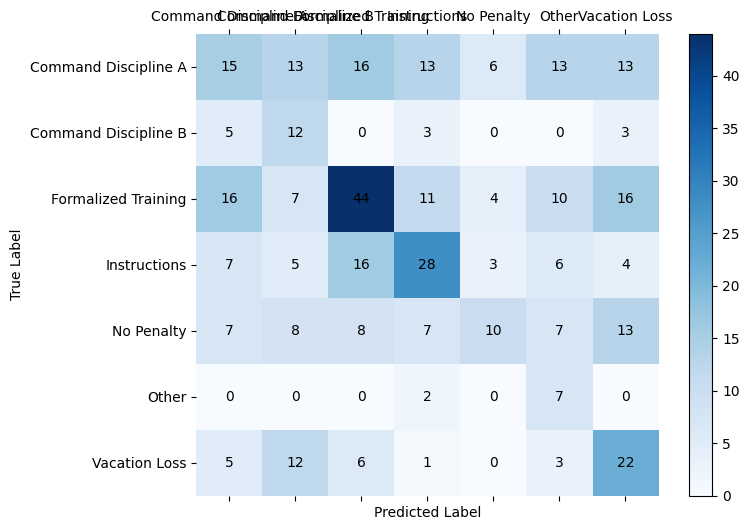

RF
              precision    recall  f1-score   support

           0       0.91      0.92      0.92        89
           1       1.00      0.96      0.98        23
           2       0.86      0.94      0.90       108
           3       0.91      0.91      0.91        69
           4       0.95      0.92      0.93        60
           5       1.00      0.89      0.94         9
           6       0.98      0.86      0.91        49

    accuracy                           0.92       407
   macro avg       0.94      0.91      0.93       407
weighted avg       0.92      0.92      0.92       407

Balanced Accuracy: 0.9126853042688063
F1-Weighted: 0.9167879862165527
F1-Macro: 0.9273176414020677


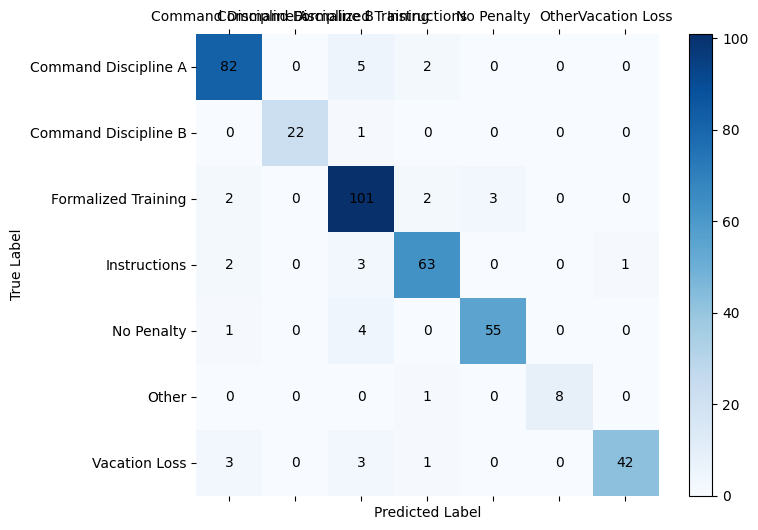

SVM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        89
           1       0.06      0.22      0.10        23
           2       0.00      0.00      0.00       108
           3       0.00      0.00      0.00        69
           4       0.11      0.23      0.15        60
           5       0.02      0.56      0.05         9
           6       0.50      0.04      0.08        49

    accuracy                           0.06       407
   macro avg       0.10      0.15      0.05       407
weighted avg       0.08      0.06      0.04       407

Balanced Accuracy: 0.14958521710961817
F1-Weighted: 0.03835959662818708
F1-Macro: 0.05356801646638336


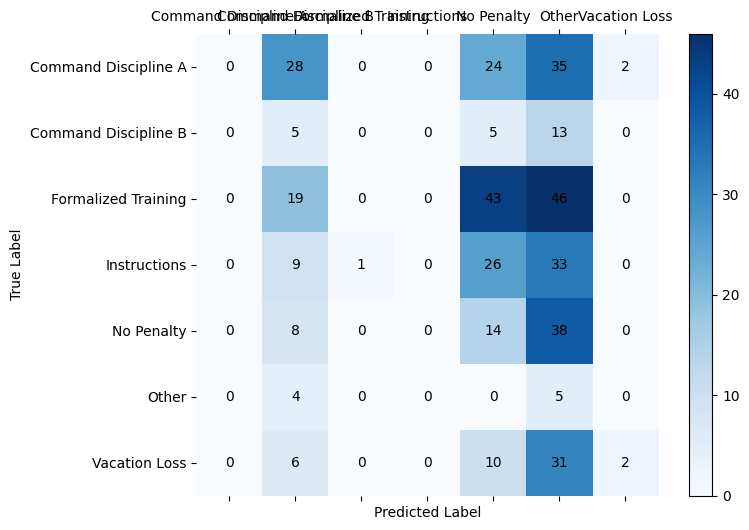

XGB
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        89
           1       1.00      0.96      0.98        23
           2       0.94      0.90      0.92       108
           3       0.93      0.90      0.91        69
           4       0.92      0.92      0.92        60
           5       0.89      0.89      0.89         9
           6       0.84      0.86      0.85        49

    accuracy                           0.90       407
   macro avg       0.91      0.90      0.91       407
weighted avg       0.90      0.90      0.90       407

Balanced Accuracy: 0.9037187691664625
F1-Weighted: 0.9022361781442656
F1-Macro: 0.905527120428152


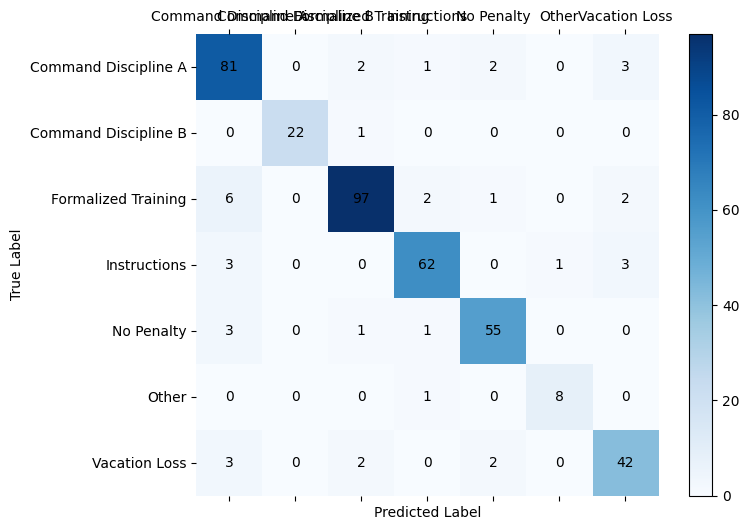

KNN
              precision    recall  f1-score   support

           0       0.74      0.71      0.72        89
           1       0.50      0.96      0.66        23
           2       0.73      0.56      0.64       108
           3       0.75      0.67      0.71        69
           4       0.76      0.78      0.77        60
           5       0.36      0.89      0.52         9
           6       0.76      0.78      0.77        49

    accuracy                           0.70       407
   macro avg       0.66      0.76      0.68       407
weighted avg       0.72      0.70      0.70       407

Balanced Accuracy: 0.7633715450650137
F1-Weighted: 0.702355398038578
F1-Macro: 0.6830839593354486


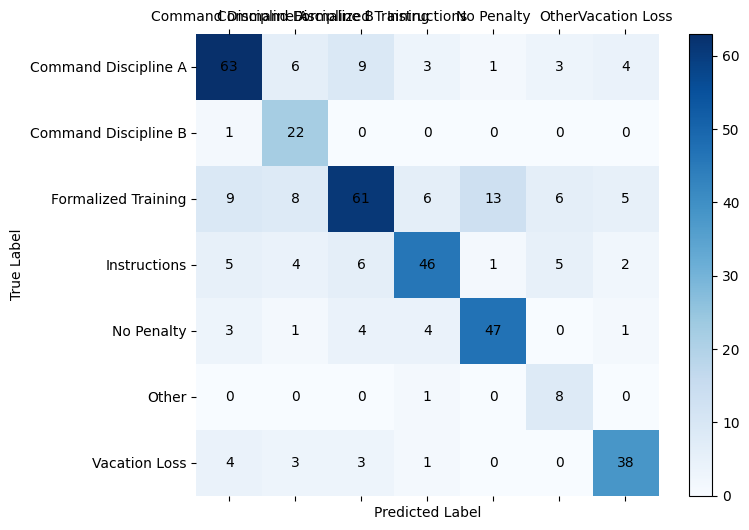

In [67]:
#fits and evaluates performance for each model
for model in model_list:
    print(model)
    model_perf_type(model, x_res3, y_res3, x_valid3, y_valid3)

In [68]:
#parameter to tune for Random Forest and XGB
params_grid = {
    'RF': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
    },
    'XGB': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
    }
}

In [69]:
top_pen_models = ["RF", "XGB"]

In [70]:
score_storage = {}
param_storage = {}

In [71]:
#hyperparameter tuning
for top_mod in top_pen_models:
    #fix cols
    x_res2.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
    
    #initiate mod
    if top_mod == "RF":
        mod = RandomForestClassifier(random_state = 2,
                               class_weight = "balanced")
    elif top_mod == "XGB":
        mod = XGBClassifier(objective='multi:softmax', 
                            num_class=7, 
                            random_state=2)
        
    #randomized grid search
    rf_gs = RandomizedSearchCV(mod, params_grid[top_mod], cv = 5,
                     scoring = "f1_weighted",
                     n_iter = 100,
                     random_state = 42,
                     n_jobs = -1)
    
    #fit
    rf_gs.fit(x_res3, y_res3)
    
    #print best params and scoes
    print(f'Best Parameters for {top_mod}:', rf_gs.best_params_)
    print(f'Best F1 Score (Weighted) for {top_mod}:', rf_gs.best_score_)
    
    #append
    score_storage[top_mod] = rf_gs.best_score_
    param_storage[top_mod] = rf_gs.best_params_



Best Parameters for RF: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Best F1 Score (Weighted) for RF: 0.9170902596530611
Best Parameters for XGB: {'subsample': 0.7, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best F1 Score (Weighted) for XGB: 0.9024668789938725


In [72]:
#Final Assessment
if score_storage["XGB"] > score_storage["RF"]:
    penalty_mod = XGBClassifier(**param_storage["XGB"])
else:
    penalty_mod = RandomForestClassifier(**param_storage["RF"])

In [73]:
#fit mod
penalty_mod.fit(x_res3, y_res3)

RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300)

In [74]:
#compute predicted
x_test3.columns = x_test3.columns.str.replace(r'[\[\]<>]', '', regex=True)
penalty_pred = penalty_mod.predict(x_test3)

In [75]:
#performance metrics
pen_conf_matrix = confusion_matrix(y_test3, penalty_pred)
pen_class_report = classification_report(y_test3, penalty_pred, zero_division = 0)
pen_fl_weighted = f1_score(y_test3, penalty_pred, average = 'weighted')

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       112
           1       0.93      0.90      0.91        29
           2       0.83      0.93      0.88       134
           3       0.95      0.84      0.89        86
           4       0.96      0.93      0.95        74
           5       1.00      1.00      1.00        12
           6       0.94      0.84      0.89        61

    accuracy                           0.90       508
   macro avg       0.93      0.91      0.91       508
weighted avg       0.90      0.90      0.90       508

F1-Weighted: 0.8979054227464026


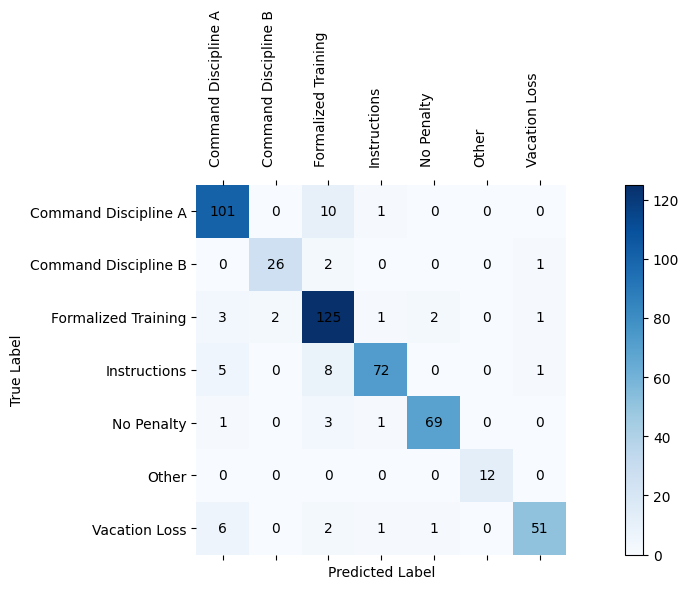

In [76]:
#printing report
print(pen_class_report)
print(f'F1-Weighted: {pen_fl_weighted}')

#confusion matrix plot 
fig, ax = plt.subplots(figsize=(12, 6))
cax = ax.matshow(pen_conf_matrix, cmap='Blues')
fig.colorbar(cax)

#add labels
ax.set_xticks(np.arange(pen_conf_matrix.shape[1]))
ax.set_yticks(np.arange(pen_conf_matrix.shape[0]))
ax.set_xticklabels(list(penalty_map.keys()))
ax.set_yticklabels(list(penalty_map.keys()))

#add axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

#rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=90, ha='left', rotation_mode='anchor')
ax.tick_params(axis='x', pad=10) 

#remove outline
for spine in ax.spines.values():
    spine.set_visible(False)

#annotate the matrix with numbers
for i in range(pen_conf_matrix.shape[0]):
    for j in range(pen_conf_matrix.shape[1]):
        ax.text(j, i, f'{pen_conf_matrix[i, j]}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

In [77]:
pd.DataFrame({
    'Feature': x_res3.columns,
    'Importance': penalty_mod.feature_importances_
}).sort_values(by = 'Importance', ascending = False).head(20)

,Feature,Importance
1,Precinct Of Incident Occurrence,0.058958
7,Officer Days On Force At Incident_zscore,0.057117
0,Incident Hour,0.054958
5,Total Complaints_z_score,0.052597
4,month,0.049980
2,year,0.040405
6,Total Substantiated Complaints_z_score,0.037444
70,Officer Race_White,0.020436
58,Outcome Of Police Encounter_Arrest,0.019971
65,Video Evidence_Yes,0.019576


In [78]:
#Penalty Mod
explainer = shap.Explainer(penalty_mod, x_train3)
shap_values = explainer(x_test3, check_additivity=False)

100%|===================| 3553/3556 [07:29<00:00]        

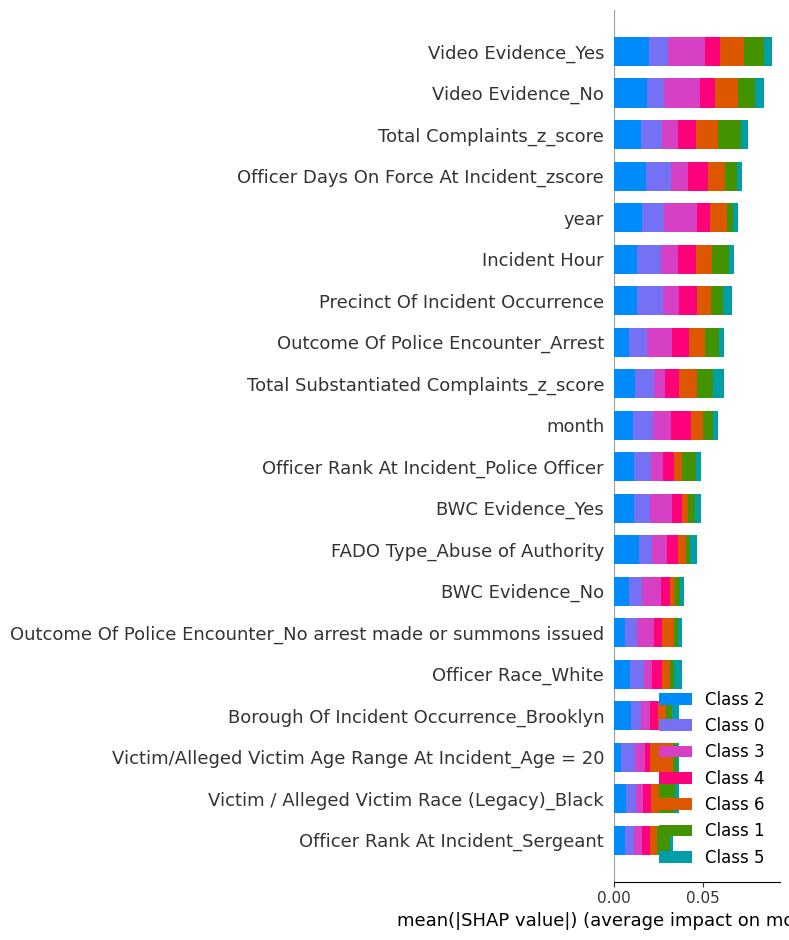

In [79]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
shap.summary_plot(shap_values, x_test3, show=False)
plt.tight_layout()
plt.show()

### Predicting Penalty Count

In [80]:
penalty_df['PenaltyCount'].value_counts()

PenaltyCount
1     2095
0      371
2+      73
Name: count, dtype: int64

In [81]:
#encoding penalty type
count_encoder = LabelEncoder()
y = count_encoder.fit_transform(penalty_df['PenaltyCount'])

In [82]:
# View the class-to-integer mapping
count_map = dict(zip(count_encoder.classes_, range(len(count_encoder.classes_))))
print("Class to Integer Mapping:", dict(zip(count_encoder.classes_, range(len(count_encoder.classes_)))))

Class to Integer Mapping: {'0': 0, '1': 1, '2+': 2}


In [83]:
#training, validation, and test sets
x_train4, x_test4, y_train4, y_test4 = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 3)
x_train4, x_valid4, y_train4, y_valid4 = train_test_split(x_train4, y_train4, test_size = 0.2, stratify = y_train4, random_state = 3)

In [84]:
#SMOTE for class imbalance
smote_penalty_c = SMOTE(random_state = 10)

#applying SMOTE to training
x_res4, y_res4 = smote_penalty_c.fit_resample(x_train4, y_train4)

In [85]:
#check class dist
print(pd.Series(y_train4).value_counts())
print(pd.Series(y_res4).value_counts())

1    1340
0     238
2      46
Name: count, dtype: int64
1    1340
0    1340
2    1340
Name: count, dtype: int64


In [86]:
def model_perf_count(model:str, x_train, y_train, x, y):
    """
    runs and prints model performance
    depending on model argument
    """
    #determine and initialize mode
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, 
                             multi_class = "multinomial",
                             class_weight='balanced',
                             random_state = 2)
    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, 
                                     class_weight='balanced',
                                     random_state = 2)
    elif model == "SVM":
        mod = SVC(kernel='rbf',
                  class_weight='balanced',
                  random_state=2)
    elif model == "XGB":
        mod = XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            random_state=2)
        x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
        x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors=5)
        
    #fit model
    mod.fit(x_train, y_train)
    
    #compute predicted
    pred = mod.predict(x)
    
    #performance metrics
    conf_matrix = confusion_matrix(y, pred)
    class_report = classification_report(y, pred, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, pred)
    fl_weighted = f1_score(y, pred, average = 'weighted')
    f1_macro = f1_score(y, pred, average = 'macro')
    
    #printing report
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1-Weighted: {fl_weighted}')
    print(f'F1-Macro: {f1_macro}')
    
    #confusion matrix plot 
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap='Blues')
    fig.colorbar(cax)

    #add labels
    ax.set_xticks(np.arange(conf_matrix.shape[1]))
    ax.set_yticks(np.arange(conf_matrix.shape[0]))
    ax.set_xticklabels(list(count_map.keys()))
    ax.set_yticklabels(list(count_map.keys()))
    
    #add axis labels
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    
    #remove outline
    for spine in ax.spines.values():
        spine.set_visible(False)

    #annotate the matrix with numbers
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center', color='black')

    plt.show()

Logistic
              precision    recall  f1-score   support

           0       0.22      0.51      0.31        59
           1       0.90      0.53      0.67       336
           2       0.12      0.75      0.21        12

    accuracy                           0.54       407
   macro avg       0.42      0.60      0.40       407
weighted avg       0.78      0.54      0.60       407

Balanced Accuracy: 0.5970708905030939
F1-Weighted: 0.6044655468149417
F1-Macro: 0.3963308870385287


C:\Users\helen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


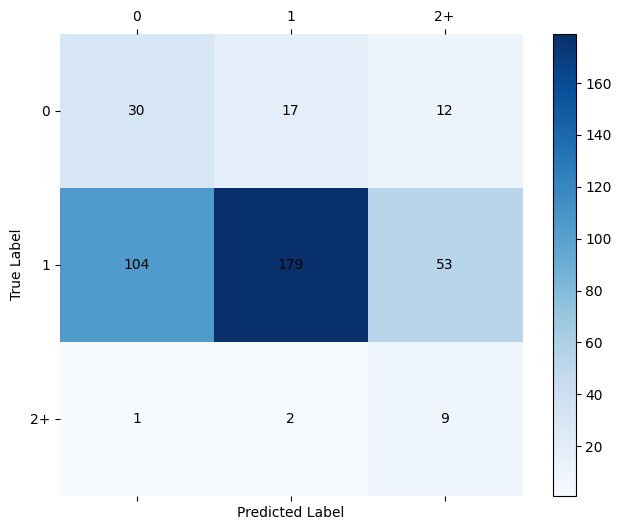

RF
              precision    recall  f1-score   support

           0       0.96      0.80      0.87        59
           1       0.95      0.99      0.97       336
           2       1.00      0.67      0.80        12

    accuracy                           0.96       407
   macro avg       0.97      0.82      0.88       407
weighted avg       0.96      0.96      0.95       407

Balanced Accuracy: 0.8191081517352704
F1-Weighted: 0.9536499393642252
F1-Macro: 0.8813771011049921


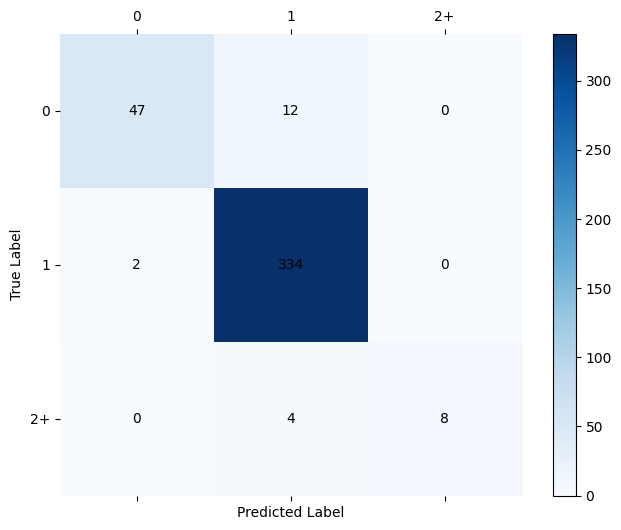

SVM
              precision    recall  f1-score   support

           0       0.11      0.36      0.17        59
           1       0.00      0.00      0.00       336
           2       0.03      0.58      0.06        12

    accuracy                           0.07       407
   macro avg       0.05      0.31      0.08       407
weighted avg       0.02      0.07      0.03       407

Balanced Accuracy: 0.31308851224105466
F1-Weighted: 0.026344890089630618
F1-Macro: 0.07674146797568958


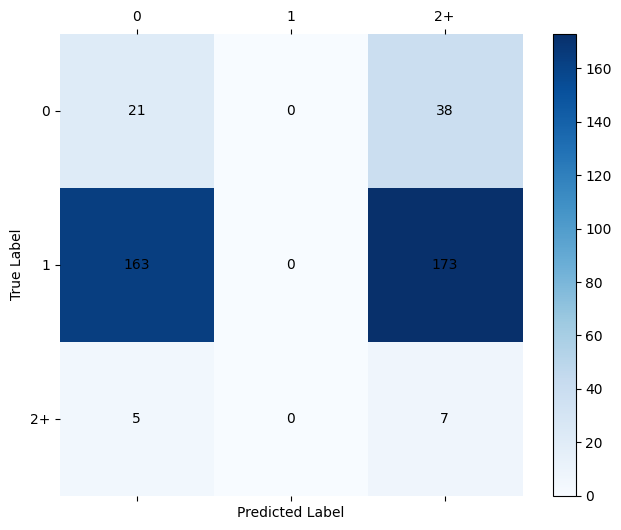

XGB
              precision    recall  f1-score   support

           0       0.98      0.88      0.93        59
           1       0.97      1.00      0.99       336
           2       1.00      0.83      0.91        12

    accuracy                           0.98       407
   macro avg       0.98      0.90      0.94       407
weighted avg       0.98      0.98      0.97       407

Balanced Accuracy: 0.903904358353511
F1-Weighted: 0.9748246406000417
F1-Macro: 0.9409854851031322


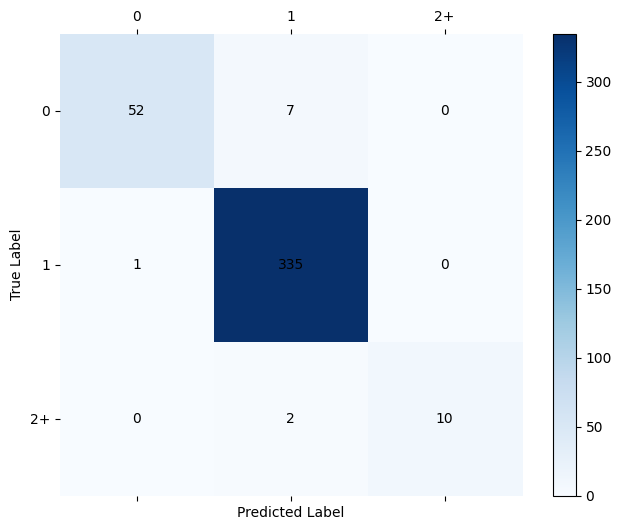

KNN
              precision    recall  f1-score   support

           0       0.51      0.95      0.66        59
           1       0.99      0.80      0.88       336
           2       0.42      0.83      0.56        12

    accuracy                           0.82       407
   macro avg       0.64      0.86      0.70       407
weighted avg       0.90      0.82      0.84       407

Balanced Accuracy: 0.8610270379338177
F1-Weighted: 0.8417563749128737
F1-Macro: 0.700564294728751


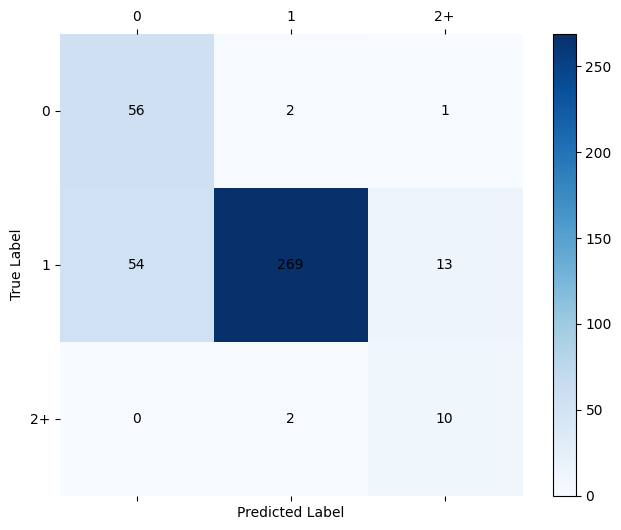

In [87]:
#list of models to go through
model_list = ["Logistic", "RF", "SVM", "XGB", "KNN"]

#fits and evaluates performance for each model
for model in model_list:
    print(model)
    model_perf_count(model, x_res4, y_res4, x_valid4, y_valid4)

In [88]:
#parameter to tune for Random Forest and XGB
params_grid = {
    'RF': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
    },
    'XGB': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
    }
}

In [89]:
top_count_models = ["RF", "XGB"]

In [90]:
score_storage = {}
param_storage = {}

In [91]:
#hyperparameter tuning
for top_mod in top_count_models:
    #fix cols
    x_res4.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
    
    #initiate mod
    if top_mod == "RF":
        mod = RandomForestClassifier(random_state = 2,
                               class_weight = "balanced")
    elif top_mod == "XGB":
        mod = XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            random_state=2)
        
    #randomized grid search
    rf_gs = RandomizedSearchCV(mod, params_grid[top_mod], cv = 5,
                     scoring = "f1_weighted",
                     n_iter = 100,
                     random_state = 42,
                     n_jobs = -1)
    
    #fit
    rf_gs.fit(x_res4, y_res4)
    
    #print best params and scoes
    print(f'Best Parameters for {top_mod}:', rf_gs.best_params_)
    print(f'Best F1 Score (Weighted) for {top_mod}:', rf_gs.best_score_)
    
    #append
    score_storage[top_mod] = rf_gs.best_score_
    param_storage[top_mod] = rf_gs.best_params_


Best Parameters for RF: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}
Best F1 Score (Weighted) for RF: 0.9860925038027908
Best Parameters for XGB: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best F1 Score (Weighted) for XGB: 0.9786502208737293


In [92]:
#Final Assessment
if score_storage["XGB"] > score_storage["RF"]:
    count_mod = XGBClassifier(**param_storage["XGB"])
else:
    count_mod = RandomForestClassifier(**param_storage["RF"])

In [93]:
#fit mod
count_mod.fit(x_res4, y_res4)

RandomForestClassifier(max_depth=30, max_features='log2', n_estimators=300)

In [94]:
#compute predicted
x_test4.columns = x_test4.columns.str.replace(r'[\[\]<>]', '', regex=True)
count_pred = count_mod.predict(x_test4)

In [95]:
#performance metrics
count_pred_conf_matrix = confusion_matrix(y_test4, count_pred)
count_pred_class_report = classification_report(y_test4, count_pred, zero_division = 0)
count_pred_fl_weighted = f1_score(y_test4, count_pred, average = 'weighted')

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        74
           1       0.96      1.00      0.98       419
           2       1.00      0.80      0.89        15

    accuracy                           0.97       508
   macro avg       0.99      0.87      0.92       508
weighted avg       0.97      0.97      0.97       508

F1-Weighted: 0.9672387604554895


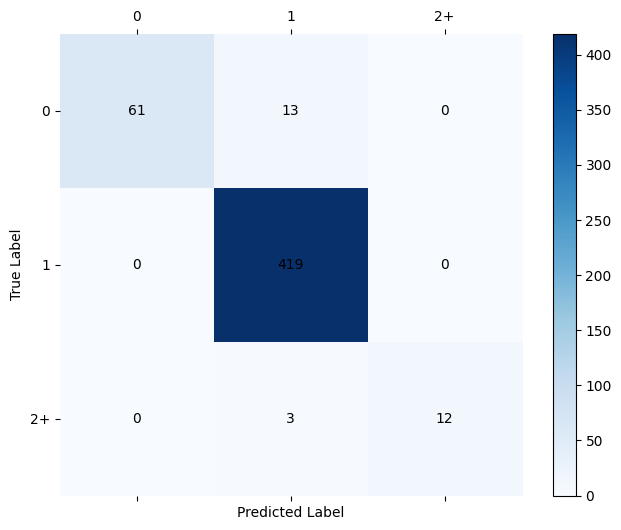

In [96]:
#printing report
print(count_pred_class_report)
print(f'F1-Weighted: {count_pred_fl_weighted}')

#confusion matrix plot 
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(count_pred_conf_matrix, cmap='Blues')
fig.colorbar(cax)

#add labels
ax.set_xticks(np.arange(count_pred_conf_matrix.shape[1]))
ax.set_yticks(np.arange(count_pred_conf_matrix.shape[0]))
ax.set_xticklabels(list(count_map.keys()))
ax.set_yticklabels(list(count_map.keys()))

#add axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

    
#remove outline
for spine in ax.spines.values():
    spine.set_visible(False)

#annotate the matrix with numbers
for i in range(count_pred_conf_matrix.shape[0]):
    for j in range(count_pred_conf_matrix.shape[1]):
        ax.text(j, i, f'{count_pred_conf_matrix[i, j]}', ha='center', va='center', color='black')

plt.show()

In [97]:
pd.DataFrame({
    'Feature': x_res4.columns,
    'Importance': count_mod.feature_importances_
}).sort_values(by = 'Importance', ascending = False).head(20)

,Feature,Importance
1,Precinct Of Incident Occurrence,0.061948
4,month,0.056165
2,year,0.056012
7,Officer Days On Force At Incident_zscore,0.048859
5,Total Complaints_z_score,0.047857
0,Incident Hour,0.047200
6,Total Substantiated Complaints_z_score,0.045051
17,Officer Rank At Incident_Police Officer,0.026693
69,Officer Race_Hispanic,0.025402
50,Location Type Of Incident_transit,0.023964


In [98]:
#Count Mod
explainer = shap.Explainer(count_mod, x_train4)
shap_values = explainer(x_test4, check_additivity=False)

 99%|===================| 1510/1524 [01:52<00:01]        

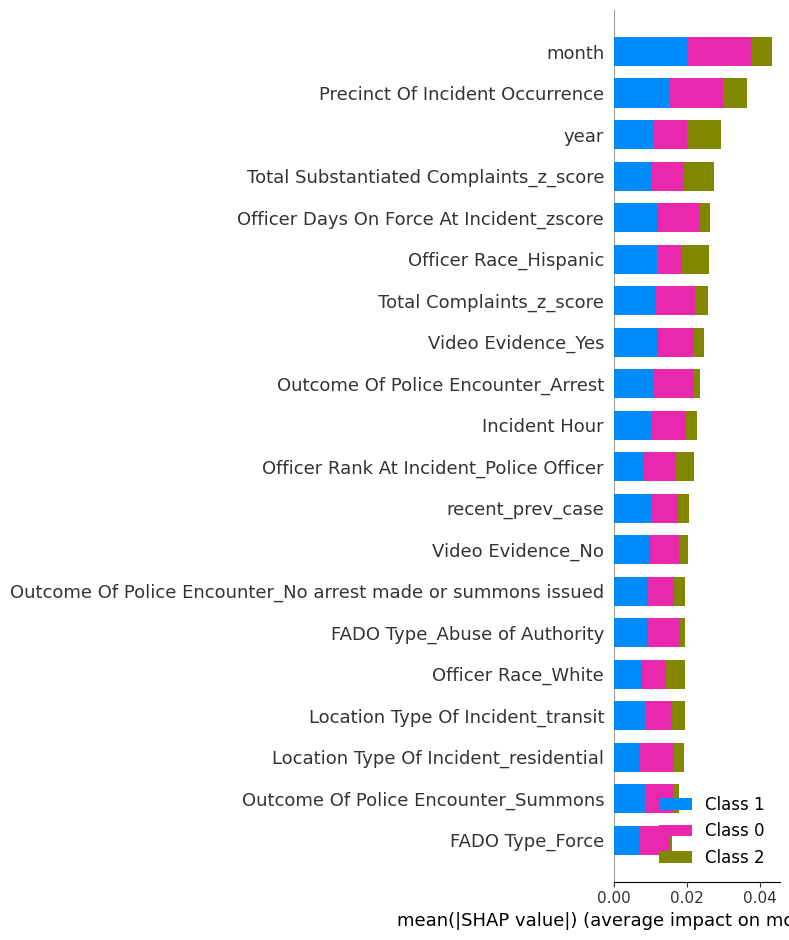

In [99]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
shap.summary_plot(shap_values, x_test4, show=False)
plt.tight_layout()
plt.show()